In [1]:
import os, warnings
from pathlib import Path

import numpy as np
import dynamo as dyn
import spateo as st
warnings.filterwarnings('ignore')

/home/pc001/anaconda3/envs/BioProjects/lib/python3.8/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/pc001/anaconda3/envs/BioProjects/lib/python3.8/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/pc001/anaconda3/envs/BioProjects/lib/python3.8/site-packag

In [2]:
from typing import Optional, Tuple, Union

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from pyvista import PolyData, UnstructuredGrid

try:
    from typing import Literal
except ImportError:
    from typing_extensions import Literal


def add_model_labels(
        model: Union[PolyData, UnstructuredGrid],
        labels: np.ndarray,
        key_added: str = "groups",
        where: Literal["point_data", "cell_data"] = "cell_data",
        colormap: Union[str, list, dict, np.ndarray] = "rainbow",
        alphamap: Union[float, list, dict, np.ndarray] = 1.0,
        mask_color: Optional[str] = "gainsboro",
        mask_alpha: Optional[float] = 0.0,
        inplace: bool = False,
) -> Tuple[Optional[PolyData or UnstructuredGrid], Optional[Union[str]]]:
    model = model.copy() if not inplace else model
    labels = np.asarray(labels).flatten()

    cu_arr = np.sort(np.unique(labels), axis=0).astype(object)
    raw_labels_hex = labels.copy().astype(object)
    raw_labels_alpha = labels.copy().astype(object)
    raw_labels_hex[raw_labels_hex == "mask"] = mpl.colors.to_hex(mask_color)
    raw_labels_alpha[raw_labels_alpha == "mask"] = mask_alpha

    # Set raw hex.
    if isinstance(colormap, str):
        if colormap in list(mpl.colormaps()):
            lscmap = mpl.cm.get_cmap(colormap)
            raw_hex_list = [mpl.colors.to_hex(lscmap(i)) for i in np.linspace(0, 1, len(cu_arr))]
            for label, color in zip(cu_arr, raw_hex_list):
                raw_labels_hex[raw_labels_hex == label] = color
        else:
            raw_labels_hex[raw_labels_hex != "mask"] = mpl.colors.to_hex(colormap)
    elif isinstance(colormap, dict):
        for label, color in colormap.items():
            raw_labels_hex[raw_labels_hex == label] = mpl.colors.to_hex(color)
    elif isinstance(colormap, list) or isinstance(colormap, np.ndarray):
        raw_hex_list = np.array([mpl.colors.to_hex(color) for color in colormap]).astype(object)
        for label, color in zip(cu_arr, raw_hex_list):
            raw_labels_hex[raw_labels_hex == label] = color
    else:
        raise ValueError("`colormap` value is wrong." "\nAvailable `colormap` types are: `str`, `list` and `dict`.")

    # Set raw alpha.
    if isinstance(alphamap, float) or isinstance(alphamap, int):
        raw_labels_alpha[raw_labels_alpha != "mask"] = alphamap
    elif isinstance(alphamap, dict):
        for label, alpha in alphamap.items():
            raw_labels_alpha[raw_labels_alpha == label] = alpha
    elif isinstance(alphamap, list) or isinstance(alphamap, np.ndarray):
        raw_labels_alpha = np.asarray(alphamap).astype(object)
    else:
        raise ValueError(
            "`alphamap` value is wrong." "\nAvailable `alphamap` types are: `float`, `list` and `dict`."
        )

    # Set rgba.
    labels_rgba = [mpl.colors.to_rgba(c, alpha=a) for c, a in zip(raw_labels_hex, raw_labels_alpha)]
    labels_rgba = np.array(labels_rgba).astype(np.float32)

    # Added rgba of the labels.
    if where == "point_data":
        model.point_data[f"{key_added}_rgba"] = labels_rgba
    else:
        model.cell_data[f"{key_added}_rgba"] = labels_rgba

    plot_cmap = None

    # Added labels.
    if where == "point_data":
        model.point_data[key_added] = labels
    else:
        model.cell_data[key_added] = labels

    return model if not inplace else None, plot_cmap

In [3]:
sample_id = "E7_8h"
os.chdir(f"/media/pc001/Yao/Projects/Project_spateo/mouse_heart/figure6")
cpo = [(41, 1209, 57), (13, 8, -3), (0, 0, 1)]

out_h5ad_path = f"droso_{sample_id}_CNS_morpho/h5ad"
out_image_path = f"droso_{sample_id}_CNS_morpho/image/CNS_curvature"
Path(out_h5ad_path).mkdir(parents=True, exist_ok=True)
Path(out_image_path).mkdir(parents=True, exist_ok=True)

In [4]:
# Read anndata
key = "morpho_curvature"
adata = st.read_h5ad(os.path.join(out_h5ad_path, f"droso_{sample_id}_CNS_tail_v4.h5ad"))
adata = adata[:, ~adata.var.index.str.startswith(f"mt:")]

import scanpy as sc
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

pc_model = st.tdr.read_model(os.path.join(out_h5ad_path, "CNS_tail_morphometrics_pc_model.vtk"))
trajectory_model = st.tdr.read_model(os.path.join(out_h5ad_path, "CNS_tail_morphometrics_trajectory_model.vtk"))
adata

AnnData object with n_obs × n_vars = 2201 × 7893
    obs: 'area', 'slices', 'anno_cell_type', 'anno_tissue', 'anno_germ_layer', 'actual_stage', 'scc', 'anno_tissue_new', 'V_z', 'anno_germ_layer_new', 'backbone_nodes', 'backbone_scc', 'segments', 'V_x', 'morpho_acceleration', 'morpho_curvature', 'morpho_curl', 'morpho_torsion', 'morpho_divergence'
    uns: 'VecFld_morpho', 'pp', 'log1p'
    obsm: '2d_realign_spatial', '3d_align_spatial', 'V_cells_mapping', 'X_cells_mapping', 'X_pca', 'X_umap', 'morpho_acceleration', 'morpho_curl', 'morpho_curvature', 'morpho_velocity', 'raw_spatial', 'tdr_spatial'
    layers: 'X_counts', 'spliced', 'unspliced'

## High curvature region

    morpho_curvature  backbone_nodes
16          0.001031              16
17          0.002275              17
18          0.002217              18
19          0.001287              19
20          0.001154              20
21          0.001506              21
22          0.002196              22
23          0.002812              23
24          0.003178              24
25          0.004004              25
26          0.004231              26
27          0.004436              27
28          0.004929              28
29          0.006175              29
30          0.007972              30
31          0.009531              31
32          0.007522              32
33          0.007036              33
34          0.006757              34
35          0.006298              35
36          0.005607              36
37          0.004866              37
38          0.004263              38
39          0.003953              39
40          0.003691              40
41          0.003182              41
4

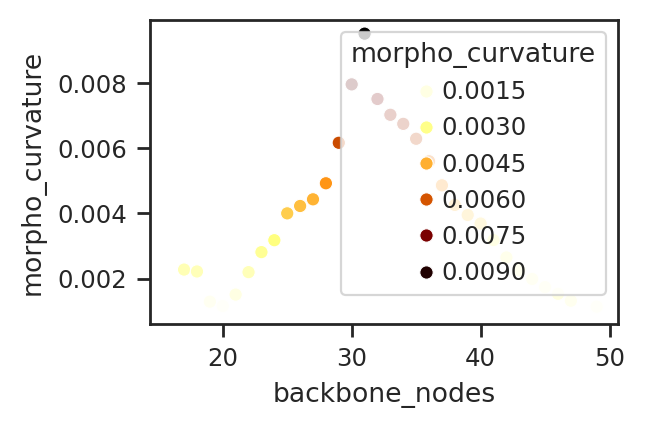

In [5]:
import pandas as pd
_data = pd.DataFrame(adata.obs[["backbone_nodes", "morpho_curvature"]]).groupby(by="backbone_nodes")["morpho_curvature"].mean()
data = pd.DataFrame(_data, index=_data.index.tolist(), columns=["morpho_curvature"])
data["backbone_nodes"] = _data.index.tolist()
print(data)
import seaborn as sns
sns.set_theme(context="paper", style="ticks")
f, ax = plt.subplots(figsize=(3, 2))
sns.scatterplot(x="backbone_nodes", y="morpho_curvature", data=data, ax=ax, hue="morpho_curvature", palette="afmhot_r")
plt.savefig(os.path.join(out_image_path, f"CNS_tail_{key}_curvature_backbone_nodes_scatterplot.pdf"), dpi=300, format="pdf", bbox_inches="tight")
plt.show()

## GLM DEGs

In [87]:
selected_genes = ["abd-A", "osp", "TBPH", "CG32856", "CCHa1-R", "Ras85D", "nrv2", "bnb",
                  "Aladin", "EndoGI", "Myo81F", "Mcm7", "gcl", "sti", "Dpit47", "Fib"]

In [90]:
data = pd.DataFrame(columns=["R1", "R2", "R3"])
for gn in selected_genes:
    region1 = [16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]
    region2 = [28, 29, 30, 31, 32, 33, 34, 35, 36, 37]
    region3 = [38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]
    
    region1_v = adata[adata.obs["backbone_nodes"].isin(region1), gn].X.A.sum()
    region2_v = adata[adata.obs["backbone_nodes"].isin(region2), gn].X.A.sum()
    region3_v = adata[adata.obs["backbone_nodes"].isin(region3), gn].X.A.sum()
    gn_data = pd.DataFrame([[region1_v/(region1_v+region2_v+region3_v), region2_v/(region1_v+region2_v+region3_v), region3_v/(region1_v+region2_v+region3_v)]], index=[gn], columns=["R1", "R2", "R3"])
    data = pd.concat([data, gn_data], axis=0, join="outer")

sns.set_theme(context="paper", style="ticks")
f, ax = plt.subplots(figsize=(6, 1))
sns.heatmap(data.T, square=True, annot=False, linewidth=.5, cmap="Reds", ax=ax, vmax=1, vmin=0)
plt.savefig(os.path.join(out_image_path, f"CNS_tail_{key}_curvature_degs_heatmap.pdf"), dpi=300, format="pdf", bbox_inches="tight")

In [92]:
for gn in selected_genes:# list(glm_data.index):
    _gn = str(gn).replace(":", "_") if ":" in gn else gn
    
    pc_index=pc_model.point_data["obs_index"].tolist()
    exp = adata[pc_index, gn].X.A.flatten()
    exp[exp <= 0] = 0
    
    amap = exp.copy()
    amap = amap / np.max(amap)
    amap[amap <= 0.2] = 0.2
    add_model_labels(model=pc_model, labels=exp, key_added=gn, alphamap=amap, where="point_data",inplace=True, colormap="Reds")
    
    st.pl.three_d_plot(
        model=pc_model,
        key=gn,
        model_style="points",
        model_size=16,
        opacity=1,
        colormap=None,
        show_legend=True,
        jupyter=False,
        off_screen=True,
        cpo=cpo,
        window_size=(2560, 2048),
        text=gn,
        filename=os.path.join(out_image_path, f"CNS_tail_{key}_glm_degs_genes_{_gn}.pdf")
    )

In [93]:
for gn in selected_genes:
    interpolated_gp_adata = st.tdr.gp_interpolation(source_adata=adata.copy(), spatial_key="3d_align_spatial", keys=gn,
                                                    target_points=np.asarray(pc_model.points), device="0",
                                                    training_iter=100)
    interpolated_gp_pc, _ = st.tdr.construct_pc(adata=interpolated_gp_adata.copy(), spatial_key="3d_align_spatial", groupby=gn,
                                                key_added=gn)
    _gn = str(gn).replace(":", "_") if ":" in gn else gn
    
    st.pl.three_d_plot(
        model=interpolated_gp_pc,
        key=gn,
        model_style="points",
        model_size=16,
        opacity=0.6,
        colormap="Reds",
        show_legend=True,
        jupyter=False,
        off_screen=True,
        cpo=cpo,
        window_size=(2560, 2048),
        text=gn,
        filename=os.path.join(out_image_path, f"CNS_tail_{key}_glm_degs_interpolated_genes_{_gn}.pdf")
    )

In [94]:
germ_adata = st.read_h5ad(f"/media/pc001/Yao/Projects/Project_drosophila/Data_v4/migration-hotspot/drosophila_E7_8h_germ_layer_new/h5ad/{sample_id}_germband_v3.h5ad")
adata = germ_adata[germ_adata.obs["anno_tissue_new"] == "CNS", :]
adata.X = adata.layers["X_counts"].copy()
adata = adata[adata.X.sum(axis=1)!=0, adata.X.sum(axis=0)!=0]
adata = adata[:, ~adata.var.index.str.startswith(f"mt:")]
adata

In [95]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

In [96]:
tissue_pc, _ = st.tdr.construct_pc(
    adata=adata.copy(),
    spatial_key="3d_align_spatial",
    groupby="anno_tissue_new",
    key_added="tissue",
    colormap={"amnioserosa": "#bdcf32", "CNS": "#ea5545", "hindgut": "#27aeef", "midgut": "#87bc45", "muscle": "#f46a9b", "salivary gland": "#ef9b20",},
)

In [97]:
for gn in selected_genes:# list(glm_data.index):
    _gn = str(gn).replace(":", "_") if ":" in gn else gn
    
    pc_index=tissue_pc.point_data["obs_index"].tolist()
    exp = adata[pc_index, gn].X.A.flatten()
    exp[exp <= 0] = 0
    
    amap = exp.copy()
    amap = amap / np.max(amap)
    amap[amap <= 0.2] = 0.2
    add_model_labels(model=tissue_pc, labels=exp, key_added=gn, alphamap=amap, where="point_data",inplace=True, colormap="Reds")
    
    st.pl.three_d_plot(
        model=tissue_pc,
        key=gn,
        model_style="points",
        model_size=16,
        opacity=1,
        colormap=None,
        show_legend=True,
        jupyter=False,
        off_screen=True,
        cpo=cpo,
        window_size=(2560, 2048),
        text=gn,
        filename=os.path.join(out_image_path, f"CNS_{key}_glm_degs_genes_{_gn}.pdf")
    )

In [98]:
for gn in selected_genes:
    interpolated_gp_adata = st.tdr.gp_interpolation(source_adata=adata.copy(), spatial_key="3d_align_spatial", keys=gn,
                                                    target_points=np.asarray(tissue_pc.points), device="0",
                                                    training_iter=100)
    interpolated_gp_pc, _ = st.tdr.construct_pc(adata=interpolated_gp_adata.copy(), spatial_key="3d_align_spatial", groupby=gn,
                                                key_added=gn)
    _gn = str(gn).replace(":", "_") if ":" in gn else gn
    
    st.pl.three_d_plot(
        model=interpolated_gp_pc,
        key=gn,
        model_style="points",
        model_size=16,
        opacity=0.6,
        colormap="Reds",
        show_legend=True,
        jupyter=False,
        off_screen=True,
        cpo=cpo,
        window_size=(2560, 2048),
        text=gn,
        filename=os.path.join(out_image_path, f"CNS_{key}_glm_degs_interpolated_genes_{_gn}.pdf")
    )

## GO term

In [100]:
import gseapy as gp
import pandas as pd
gp.get_library_name(organism="Fly")

In [101]:
# GO-biologial process
go_folder = os.path.join(out_image_path, f"{key}_GO")
Path(go_folder).mkdir(parents=True, exist_ok=True)

go_bp = gp.enrichr(
        gene_list=selected_genes,
        gene_sets="GO_Biological_Process_2018",
        organism="Fly",
        outdir=go_folder,
        no_plot=True,
        verbose=True
)
go_bp_results = pd.read_csv(os.path.join(go_folder, f"GO_Biological_Process_2018.Fly.enrichr.reports.txt"), sep="\t")
gp.barplot(go_bp_results, column='Combined Score', title='GO_Biological_Process_2018', cutoff=0.05, top_term=50, figsize=(5, 20), color="black",
            ofname=os.path.join(go_folder, f"{key}_GO_Biological_Process_2018_selected_barplot.pdf"))
gp.dotplot(go_bp_results, column='Combined Score', title='GO_Biological_Process_2018', cmap='Spectral', cutoff=0.05, top_term=50, figsize=(5, 20),
            ofname=os.path.join(go_folder, f"{key}_GO_Biological_Process_2018_dotplot.pdf"))